# Treeshap sample for xgboost 

In [1]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [32]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [30]:
X_display.head(1)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States


In [33]:
y_display

array([False, False, False, ..., False, False,  True])

In [4]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36398
[200]	test-logloss:0.31758
[300]	test-logloss:0.30065
[400]	test-logloss:0.29170
[500]	test-logloss:0.28655
[600]	test-logloss:0.28358
[700]	test-logloss:0.28174
[800]	test-logloss:0.28061
[900]	test-logloss:0.27988
[1000]	test-logloss:0.27939
[1100]	test-logloss:0.27906
[1177]	test-logloss:0.27888


## xgboost 特徵重要性

xgboost 提供特徵重要性，幫助我們理解特徵對模型的結果影響程度。
並且 xgboost 提供了多種計算特徵重要性的方法，他是從不同的面向，來評估特徵是否重要，而不同面向，也會導致特徵重要性的排序不同。

而這個傳統的特徵重要性的方法，有可能不是和模型預測結果完全一致。
例如：某特徵可能在很多樹中被頻繁地使用(高權重)，但它對於最終的貢獻可能不如其他特徵大，所以才有 shap 的方式出現。

### 不同的特徵重要

1. 權重(weight) ：特徵在所有樹中被用作分割點的次數。
2. 增益（Gain）：特徵的平均增益，即使用該特徵分割所帶來的信息增益。
3. 覆蓋（Cover）：特徵在分割點處覆蓋的樣本數量。


## shap 值的一致性保證
shap (shap additive explanations) 值基於博弈理論中 shap value ，為貢獻提供了一種一致的度量。 shap 值也會考慮特徵組合，綜合給出每個特徵對於預測結果的平均貢獻，這種方法通過一個全局的視角保證特徵重要性一致，也很準確反映特徵對模型預測的影響。

### xgboost 缺發的
1. 高頻率使用不等於高影嚮度
2. 缺乏全局勢角
3. 缺乏交互作用的影響

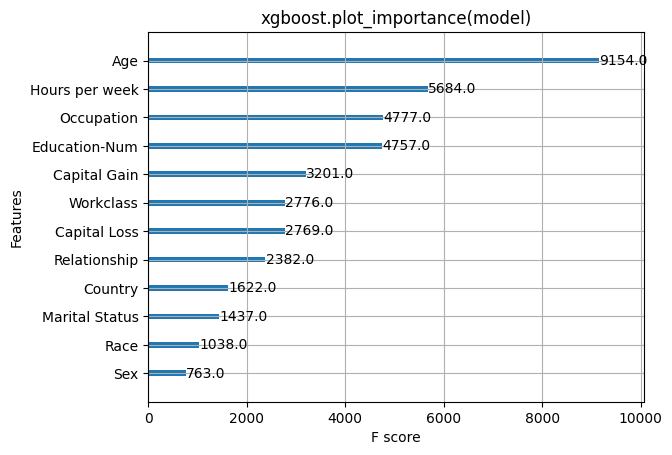

In [5]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

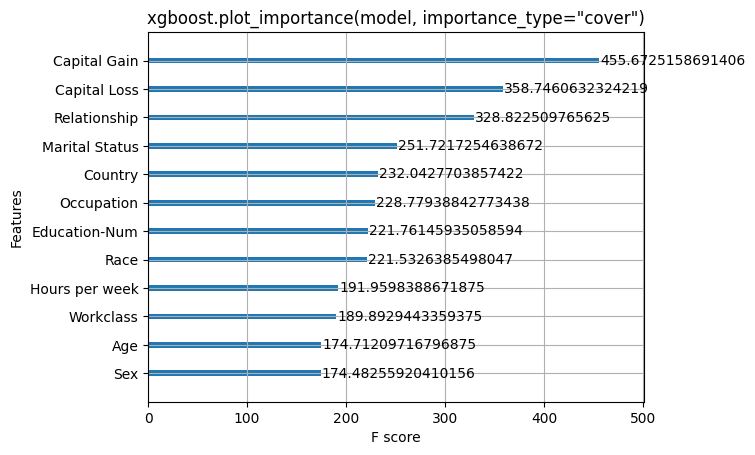

In [6]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()


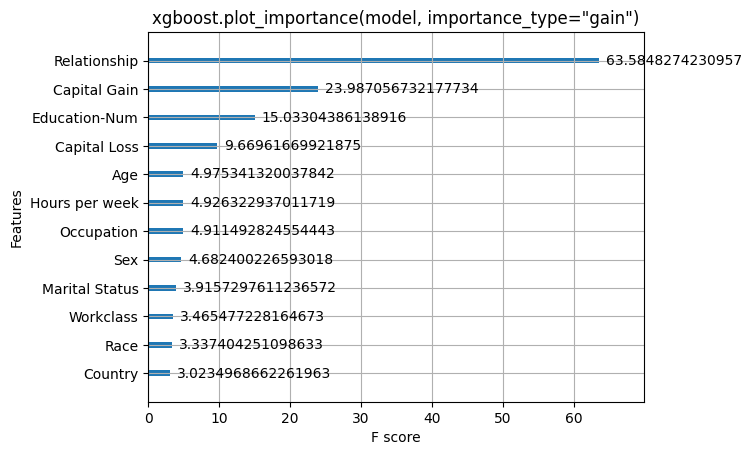

In [7]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

從上方三圖，顯示 xgboost 於三面向的特徵重要性排序。

Tree SHAP是一種特殊的SHAP值計算方法，專門針對基於樹的模型（如XGBoost、隨機森林和LightGBM等）。它利用了樹模型的結構特性，能夠比一般的SHAP值計算方法更有效率地計算出每個特徵對每個預測結果的貢獻。

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[10:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [10]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])


In [11]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :]
)

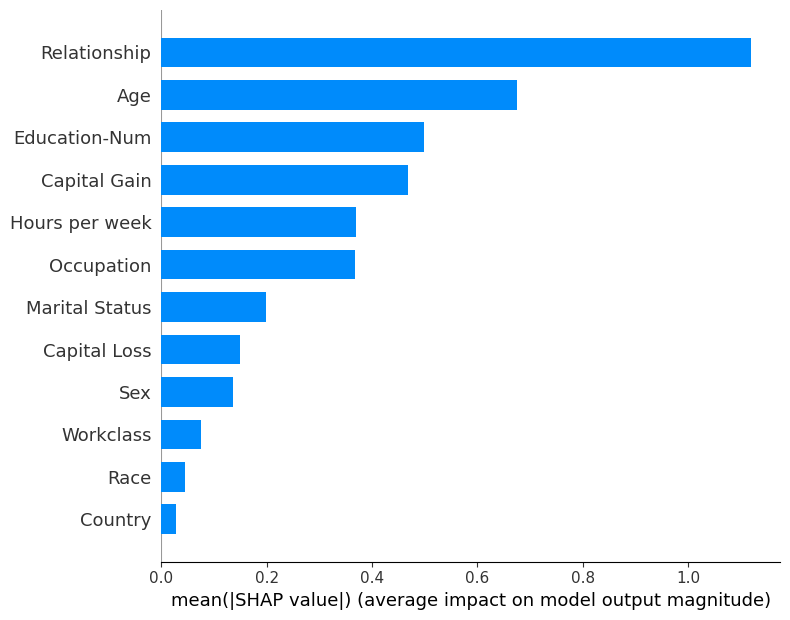

In [12]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

下圖 shap summary 解釋：

- Relationship: 越大表示預測機率越大
- Age : 越小表示預測機率越小
- Sex : 女性越大表示越大 

- Capital Gain 特征的影响对于个别样本可能非常大（散点向右延伸较远），但对于大多数样本影响较小（散点在中心聚集）

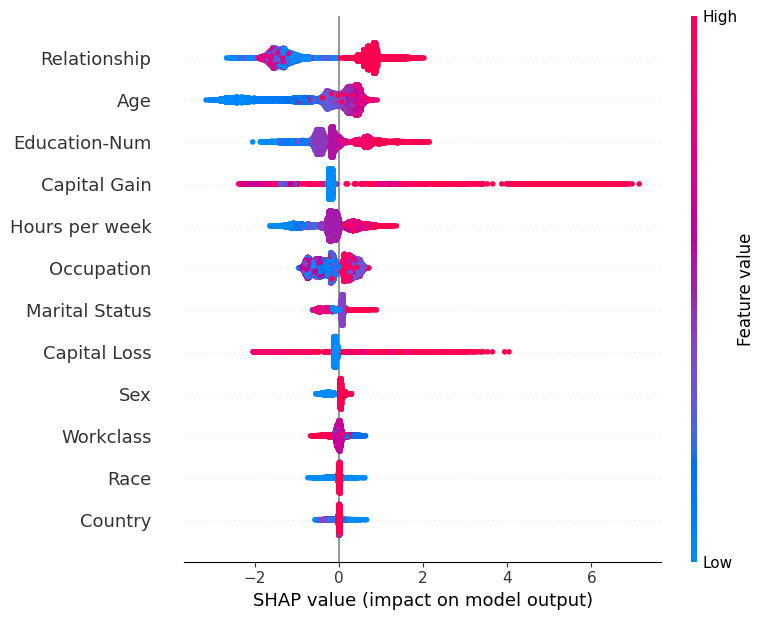

In [13]:
shap.summary_plot(shap_values, X)

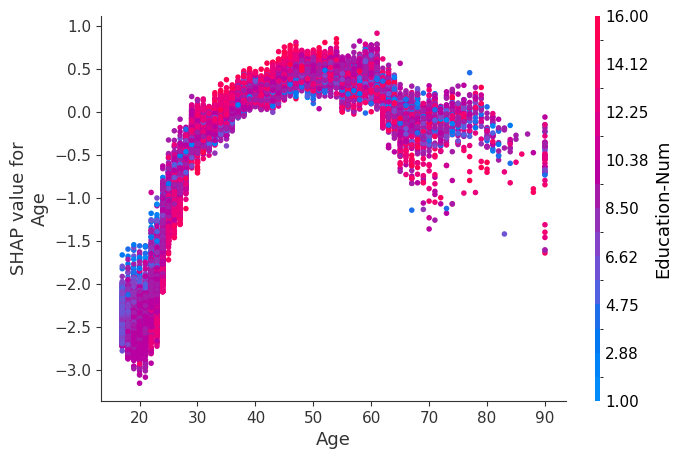

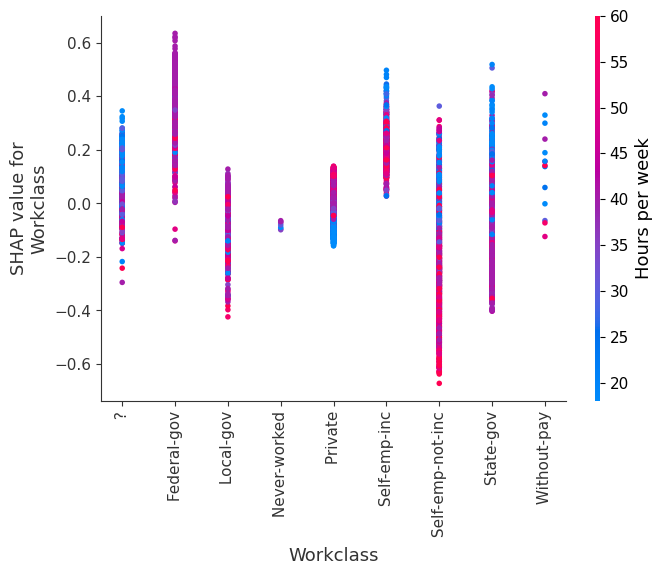

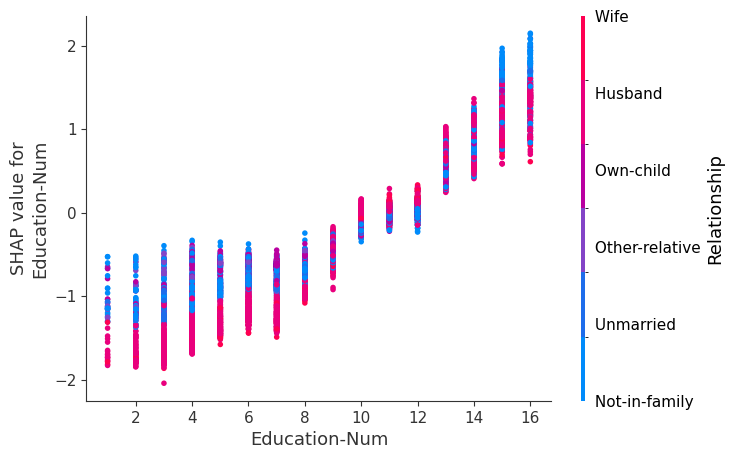

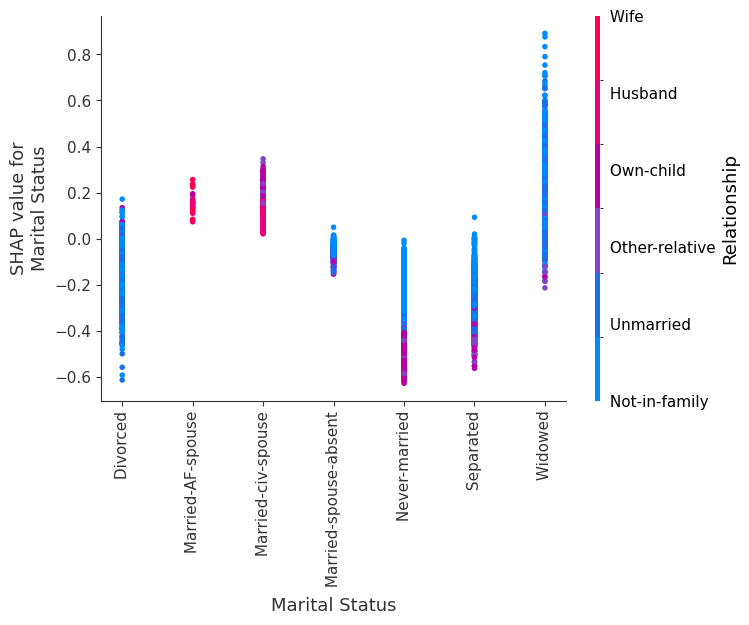

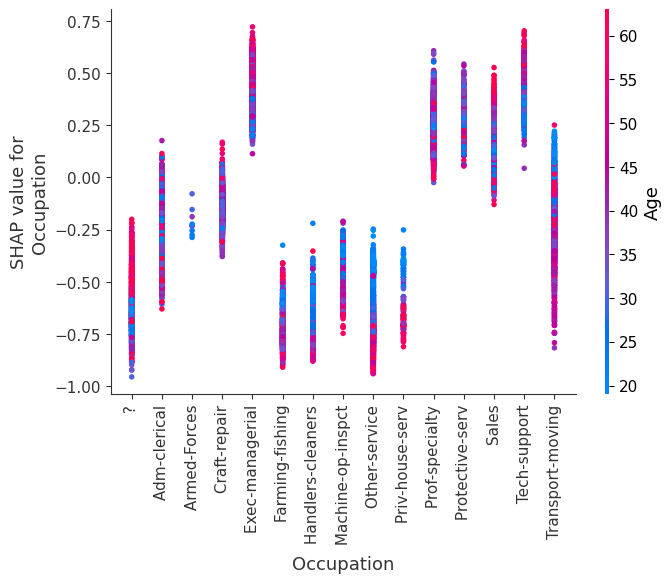

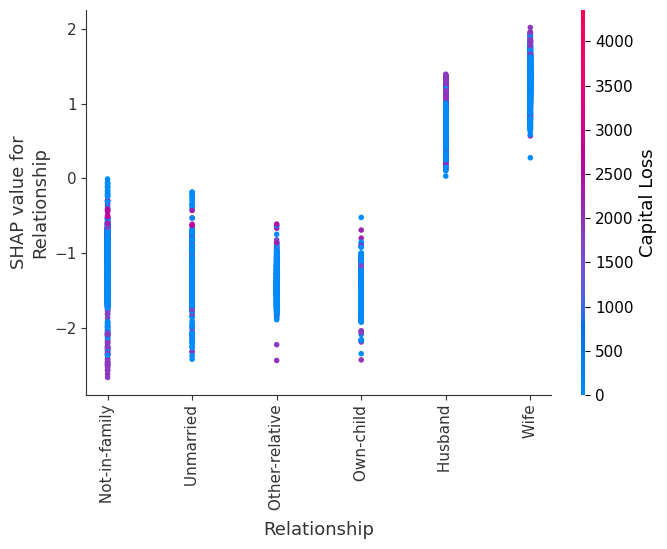

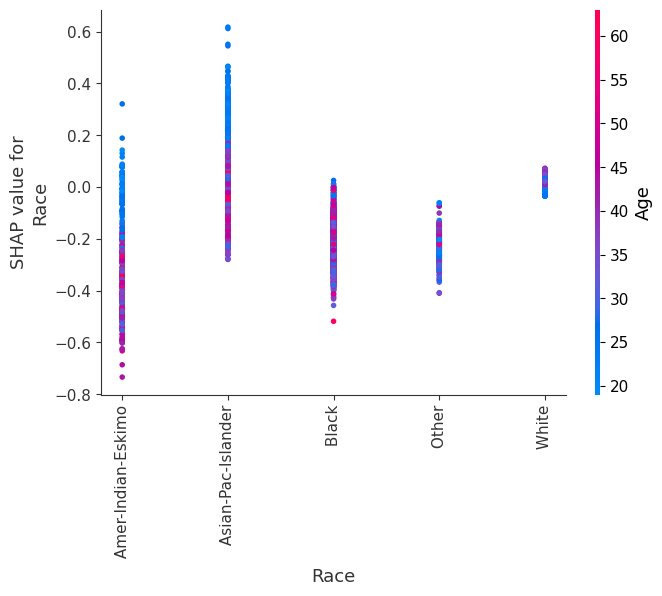

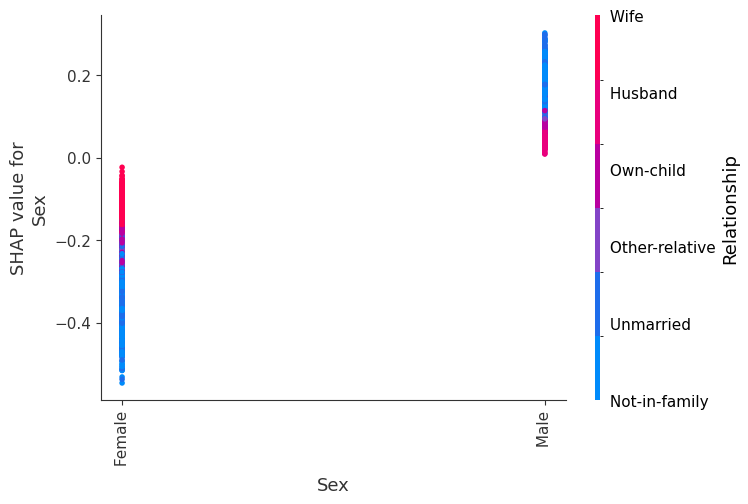

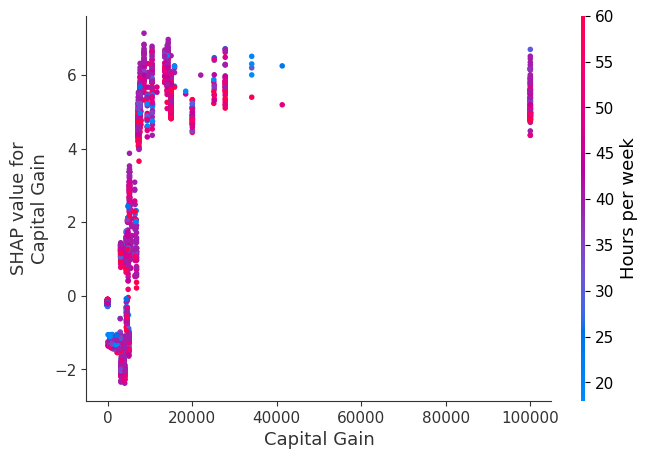

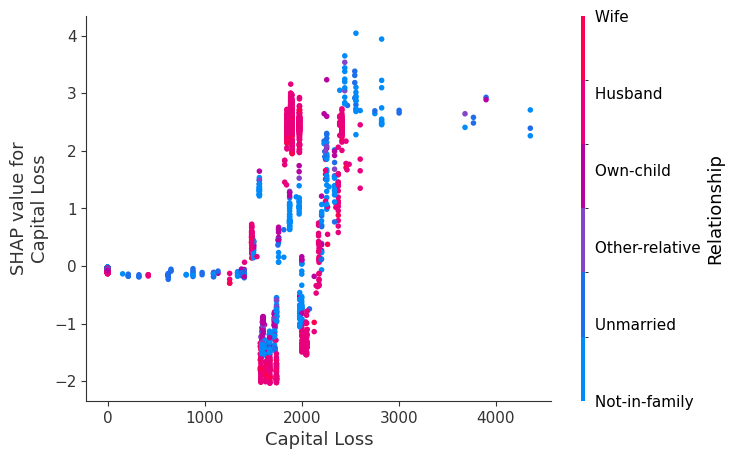

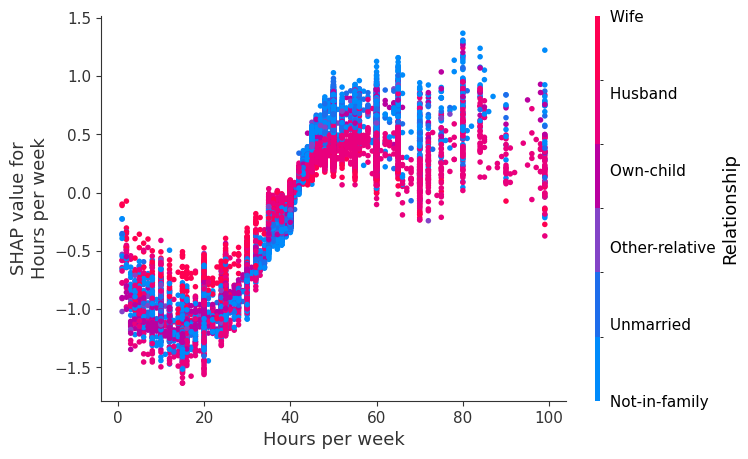

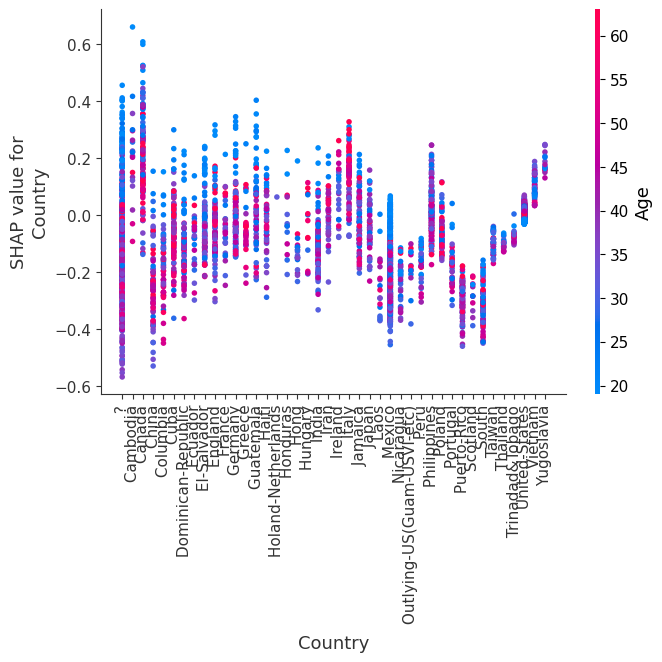

In [15]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

In [16]:
X_train

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
12011,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
23599,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
23603,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
6163,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
14883,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
5699,23.0,4,9.0,4,12,0,4,1,0.0,0.0,40.0,39
10742,37.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
16921,27.0,6,5.0,2,3,4,4,1,0.0,0.0,40.0,39
25796,46.0,4,16.0,2,10,4,4,1,0.0,2415.0,55.0,39


In [18]:
shap_values = explainer.shap_values(X_train)
shap_values

array([[ 0.4432322 ,  0.01161209, -0.21452676, ..., -0.06188475,
        -0.15247549,  0.2129422 ],
       [ 0.56499815,  0.43235475,  0.96236676, ..., -0.0494496 ,
         0.5984734 , -0.11065093],
       [-2.6046684 , -0.04308102, -0.00960531, ..., -0.07927433,
        -0.24116501, -0.01131846],
       ...,
       [-0.60868937, -0.02412233, -1.1459198 , ..., -0.08425916,
        -0.12328912,  0.00647056],
       [ 0.4644408 ,  0.04049716,  1.5804936 , ...,  2.3572893 ,
         0.25910404,  0.02102552],
       [ 0.5236708 ,  0.03220026, -0.10846435, ..., -0.05106116,
        -0.1060512 ,  0.00630807]], dtype=float32)

In [20]:
import pandas as pd 

shap_values_df = pd.DataFrame(shap_values, columns=X_train.columns)


shap_values_df.head(10)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0.443232,0.011612,-0.214527,-0.119597,-0.732925,-1.500051,0.013509,-0.270029,-0.197571,-0.061885,-0.152475,0.212942
1,0.564998,0.432355,0.962367,0.529619,0.321470,-1.008866,0.053683,0.298174,-0.153525,-0.049450,0.598473,-0.110651
2,-2.604668,-0.043081,-0.009605,-0.510714,-0.118267,-1.550201,-0.144947,0.072168,-0.209077,-0.079274,-0.241165,-0.011318
3,-1.327056,-0.050288,-0.145938,-0.475000,0.172477,-1.564523,0.006982,0.080560,-0.202770,-0.069733,-1.058157,0.008640
4,0.665745,0.013429,0.692414,-0.126157,-0.274455,-1.518501,0.010992,0.177407,-0.186846,-0.066716,-0.361252,0.013049
5,-0.612055,0.160308,-0.082560,-0.093099,-0.675833,-1.601460,0.016142,-0.259362,-0.201550,-0.060525,-1.014230,-0.000675
6,0.203339,0.085409,-0.152144,-0.314247,-0.773230,-1.253878,0.020681,0.189342,-0.180659,-0.050965,0.407278,0.004901
7,-0.269764,0.019070,-0.499961,0.087747,0.139999,0.667741,0.029734,0.049444,-0.198829,-0.078824,0.345160,0.010399
8,0.439501,0.004630,-0.603856,-0.067690,-0.756796,-1.589697,-0.273776,-0.446072,-0.197010,-0.050135,-0.214065,0.004990
9,0.220585,0.011104,-0.468270,-0.181504,-0.218879,-1.274900,0.025829,0.144526,-0.183644,-0.048687,-0.181920,0.004428


In [24]:
top_features = pd.DataFrame(columns=['Sample_Index', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4','Feature_5',
                                     'SHAP_1', 'SHAP_2','SHAP_3',  'SHAP_4',  'SHAP_5'])
                                     
                                 

# 对每个样本循环
for i in range(shap_values_df.shape[0]):
    # 获取当前样本的SHAP值，并按照绝对值降序排列
    sorted_shap_values = shap_values_df.iloc[i].abs().sort_values(ascending=False)
    top_5_features = sorted_shap_values.head(5)
    # 获取特征名称和相应的SHAP值
    features = top_5_features.index.tolist()
    shaps = top_5_features.values.tolist()
    # 将结果加入top_features DataFrame中
    top_features = top_features.append(pd.DataFrame([[i] + features + shaps], 
                                                    columns=top_features.columns), ignore_index=True)

top_features.head()  # 显示前几个样本的信息

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Sample_Index,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,SHAP_1,SHAP_2,SHAP_3,SHAP_4,SHAP_5
0,0,Relationship,Occupation,Age,Sex,Education-Num,1.500051,0.732925,0.443232,0.270029,0.214527
1,1,Relationship,Education-Num,Hours per week,Age,Marital Status,1.008866,0.962367,0.598473,0.564998,0.529619
2,2,Age,Relationship,Marital Status,Hours per week,Capital Gain,2.604668,1.550201,0.510714,0.241165,0.209077
3,3,Relationship,Age,Hours per week,Marital Status,Capital Gain,1.564523,1.327056,1.058157,0.475000,0.202770
4,4,Relationship,Education-Num,Age,Hours per week,Occupation,1.518501,0.692414,0.665745,0.361252,0.274455


In [27]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.2 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 435.1 kB/s eta 0:00:000:00:01


In [28]:
import xgboost as xgb
import shap
import pandas as pd
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split

# 加载数据集
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# 将数据集分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化leave-one-out编码器
loo_encoder = LeaveOneOutEncoder()

# 对训练数据集应用leave-one-out编码
X_train_encoded = loo_encoder.fit_transform(X_train, y_train)

# 对测试数据集应用leave-one-out编码
X_test_encoded = loo_encoder.transform(X_test)

# 使用XGBoost训练模型
model = xgb.XGBClassifier()
model.fit(X_train_encoded, y_train)

# 计算SHAP值
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_encoded)

# 初始化DataFrame以存储每个样本的前五个特征和对应的SHAP值
top_shap = pd.DataFrame(index=X_train.index, columns=[f'Top_{i}_Feature' for i in range(1, 6)] +
                                                          [f'Top_{i}_SHAP' for i in range(1, 6)])

# 对每个样本计算前五个最重要的特征
for i in range(X_train_encoded.shape[0]):
    # 获取当前样本的SHAP值，并按照绝对值降序排列
    shap_values_sample = pd.Series(shap_values[i], index=X_train_encoded.columns).abs().sort_values(ascending=False)
    top_features = shap_values_sample.head(5).index
    top_shap_values = shap_values_sample.head(5).values
    
    # 填充DataFrame
    top_shap.iloc[i, :5] = top_features
    top_shap.iloc[i, 5:] = top_shap_values

# 显示结果
top_shap.head()


[13:24:38] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


,Top_1_Feature,Top_2_Feature,Top_3_Feature,Top_4_Feature,Top_5_Feature,Top_1_SHAP,Top_2_SHAP,Top_3_SHAP,Top_4_SHAP,Top_5_SHAP
5514,Relationship,Education-Num,Hours per week,Sex,Marital Status,1.06834,0.740957,0.611793,0.462905,0.402539
19777,Capital Loss,Relationship,Occupation,Hours per week,Marital Status,4.426803,1.276936,0.49125,0.456872,0.189579
10781,Relationship,Education-Num,Age,Marital Status,Hours per week,0.934742,0.518352,0.469583,0.322255,0.320182
32240,Age,Occupation,Hours per week,Relationship,Marital Status,2.26153,0.907673,0.832451,0.780734,0.319749
9876,Relationship,Age,Occupation,Marital Status,Hours per week,1.026236,0.739128,0.537982,0.406686,0.163302


In [29]:
X_train_encoded.head(1)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
5514,33.0,2,13.0,4,10,0,4,0,0.0,0.0,50.0,39
